In [2]:
suppressPackageStartupMessages(library(dplyr))
library(ggplot2)
suppressPackageStartupMessages(library(Seurat))
library(Signac)
library(pheatmap)
library(RColorBrewer)
library(harmony)
library(SeuratDisk)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

library(repr)

Warning message:
“package ‘SeuratObject’ was built under R version 4.4.3”
Warning message:
“package ‘sp’ was built under R version 4.4.2”
Loading required package: Rcpp

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Warning message:
“package ‘scales’ was built under R version 4.4.3”
Warning message:
“package ‘Matrix’ was built under R version 4.4.3”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




## ATAC integration: separate neu and nonn

In [4]:
l3meta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", sep = "\t")
atacmeta <- read.csv("../../ref/hba_ATAC/hba.whole.cell2anno.txt", sep = "\t")
head(atacmeta)

,sample,barcode,cellclass,subclass,celltype
,<chr>,<chr>,<chr>,<chr>,<chr>
1,LL_173,AAACTACCAGCAAACACCACAT,NonN,ASCT,ASCT_2
2,LL_173,AGCATGGAGAATTAGGAGGTCT,NonN,ASCT,ASCT_1
3,LL_173,CCAGGTCGTAGTCAATTCTCAG,NonN,ASCT,ASCT_1
4,LL_173,CCGTTCAGATATGTGCATCTGG,NonN,ASCT,ASCT_1
5,LL_173,CGGTAACTTGATCTCGCCACTT,NonN,ASCT,ASCT_3
6,LL_173,GACCTAAGGAATAACCCGCTAA,NonN,ASCT,ASCT_1


In [12]:
mmg <- qs::qread("MiniAtlas_RNA_merged_dual_filt_clean_250520_subset_subclass_for_int.qs")
qcell <- mmg@meta.data %>% filter(class == "NonN") %>% rownames
mmg2 <- subset(mmg, cells = qcell)
mmg2[["RNA"]] <- as(mmg2[["RNA"]], "Assay")
mmg2 <- seurat_onestep_clust(mmg2, batch.label = "donor")

qcell <- mmg@meta.data %>% filter(class != "NonN") %>% rownames
mmg3 <- subset(mmg, cells = qcell)
mmg3[["RNA"]] <- as(mmg3[["RNA"]], "Assay")
mmg3 <- seurat_onestep_clust(mmg3, batch.label = "donor")

Warning message:
“Assay RNA changing from Assay5 to Assay”


Perform log CPM normalization...


Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


Perform variable features selection using Brennecke's method...
number of variable genes calculated by hicat method: 2077


Warning message:
“Overwriting miscellanous data for hicat_vg”


Perform data scaling and PCA...


Centering and scaling data matrix



Number of PC selected for downstream analysis: 28


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Warning message:
“Number of dimensions changing from 30 to 28”


Number of neighbors selected for downstream analysis: 15
Perform UMAP embedding...
resolution used for leiden clustering: 0.3


Warning message:
“Assay RNA changing from Assay to Assay5”
Warning message:
“Assay RNA changing from Assay5 to Assay”


Perform log CPM normalization...
Perform variable features selection using Brennecke's method...
number of variable genes calculated by hicat method: 3816


Warning message:
“Overwriting miscellanous data for hicat_vg”


Perform data scaling and PCA...


Centering and scaling data matrix



[1] "Downsample PC matrix to 25000 cells to calculate significant PC components"
Number of PC selected for downstream analysis: 34


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Warning message:
“Number of dimensions changing from 30 to 34”


Number of neighbors selected for downstream analysis: 15
Perform UMAP embedding...
resolution used for leiden clustering: 0.3


Warning message:
“Assay RNA changing from Assay to Assay5”


In [5]:
### read atac gene score
data <- read_h5ad("../../ref/hba_ATAC/hba_subsample_gene_score_250601.nonn.h5ad")
ref2 <- CreateSeuratObject(counts = t(data$X), meta.data = data$obs)
qdim <- data$obsm$X_spectral
rownames(qdim) <- data$obs_names
ref2[["spectral"]] <- CreateDimReducObject(embeddings = qdim, assay = "RNA", key = "SP_")

data <- read_h5ad("../../ref/hba_ATAC/hba_subsample_gene_score_250601.neu.h5ad")
ref3 <- CreateSeuratObject(counts = t(data$X), meta.data = data$obs)
qdim <- data$obsm$X_spectral
rownames(qdim) <- data$obs_names
ref3[["spectral"]] <- CreateDimReducObject(embeddings = qdim, assay = "RNA", key = "SP_")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Warning message:
“No columnames present in cell embeddings, setting to 'SP_1:30'”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Warning message:
“No columnames present in cell embeddings, setting to 'SP_1:30'”


In [13]:
intersect(rownames(ref2), VariableFeatures(mmg2)) %>% length

[1] 2057

In [14]:
ref2 <- NormalizeData(ref2)
ref2 <- ScaleData(ref2, features = rownames(ref2))
transfer.anchors <- FindTransferAnchors(reference = mmg2, query = ref2, features = VariableFeatures(mmg2),
                                        reference.assay = "RNA", query.assay = "RNA", reduction = "cca")

refdata <- GetAssayData(mmg2, assay = "RNA", slot = "data")[VariableFeatures(mmg2), ]
imp2 <- TransferData(anchorset = transfer.anchors, refdata = refdata, 
                     weight.reduction = ref2[["spectral"]], dims = 1:30)
imp2

Normalizing layer: counts

Centering and scaling data matrix

Warning message:
“20 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 2057 features.”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16094 anchors

Finding integration vectors

Finding integration vector weights

Transfering 2077 features onto reference data



Assay data with 2077 features for 11570 cells
First 10 features:
 ENSG00000238009, MRPL20-DT, ATAD3C, ENSG00000269978, SLC2A5, PIK3CD,
PIK3CD-AS2, RBP7, CORT, ENSG00000287727 

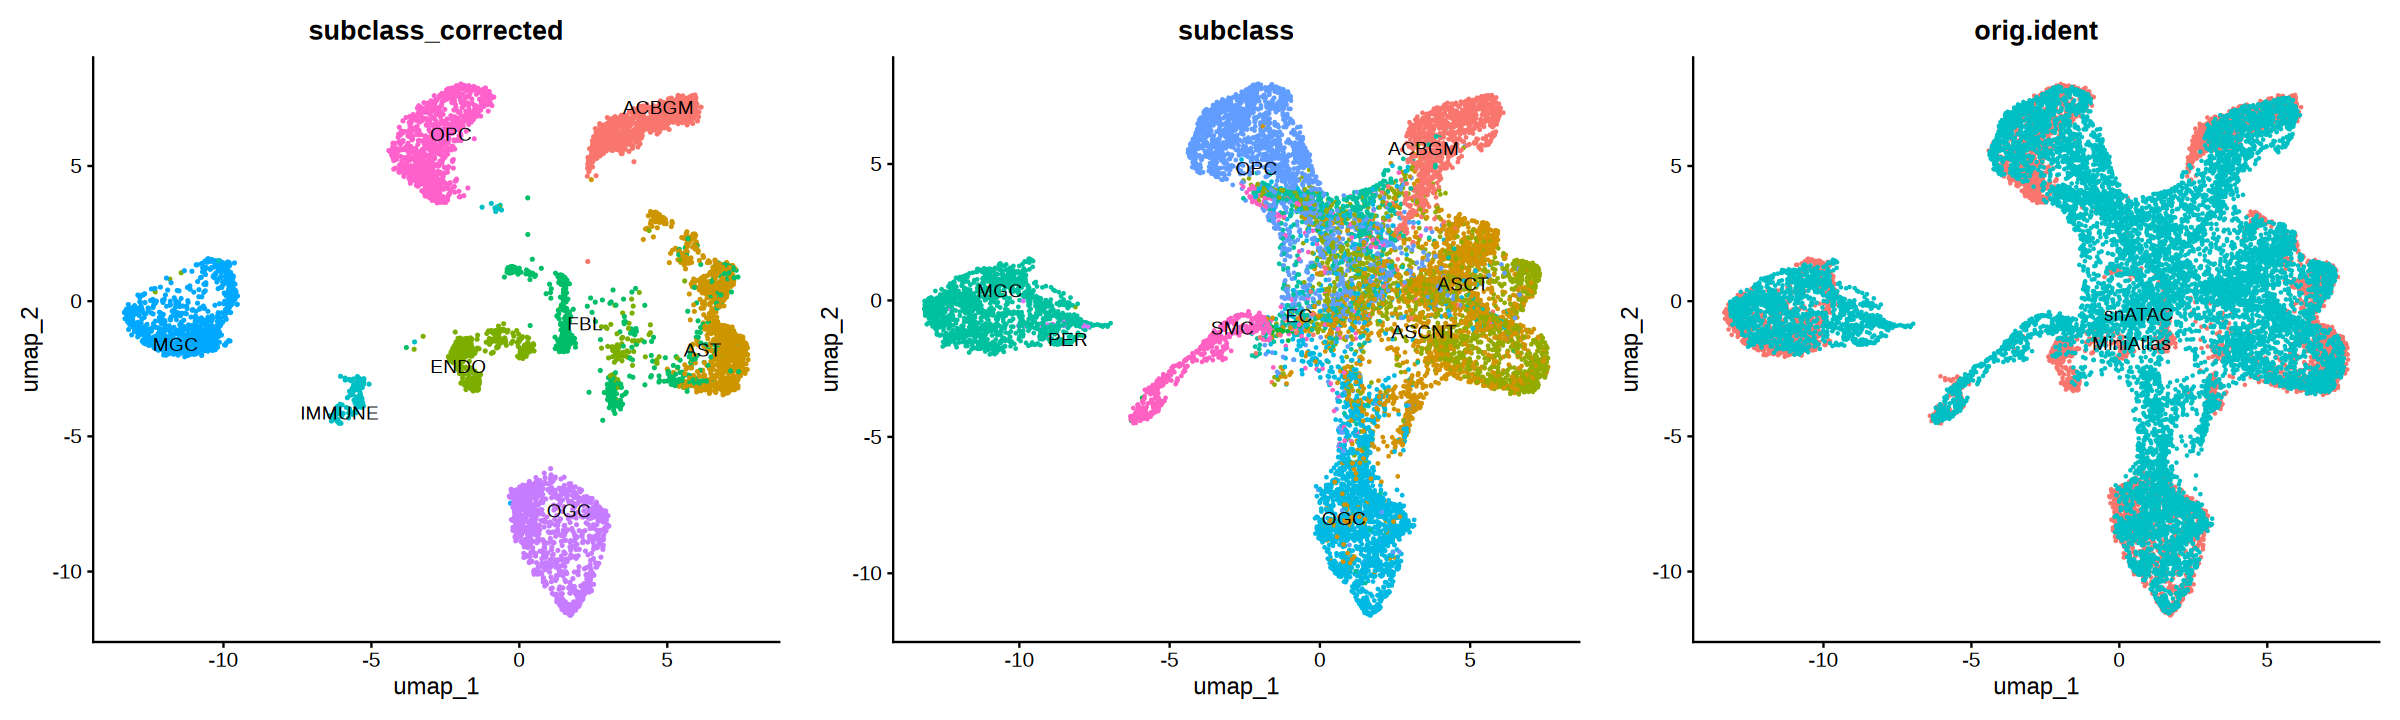

In [53]:
emp <- CreateSeuratObject(imp2, meta.data = ref2@meta.data)
imp2 <- merge(x = mmg2, y = emp)
imp2 <- ScaleData(imp2, features = VariableFeatures(mmg2), do.scale = FALSE)
imp2 <- RunPCA(imp2, features = VariableFeatures(mmg2), verbose = FALSE)
imp2 <- RunUMAP(imp2, dims = 1:35)
imp2 <- FindNeighbors(imp2, reduction = "pca", dims = 1:35)
imp2 <- FindClusters(imp2, resolution = 1)

imp2@meta.data[is.na(imp2$subclass_corrected), ]$orig.ident <- "snATAC"
imp2@meta.data[!is.na(imp2$subclass_corrected), ]$orig.ident <- "MiniAtlas"

options(repr.plot.width = 20, repr.plot.height = 6)
t1 <- DimPlot(imp2, group.by = c("subclass_corrected"), 
              cells = colnames(mmg2), label = T, repel = T) + NoLegend()
t2 <- DimPlot(imp2, group.by = c("subclass"), 
              cells = colnames(ref2), label = T, repel = T) + NoLegend()
t3 <- DimPlot(imp2, group.by = c("orig.ident"), label = T, repel = T) + NoLegend()

cowplot::plot_grid(t1, t2, t3, ncol = 3)

Using ovlpScore as value column: use value.var to override.



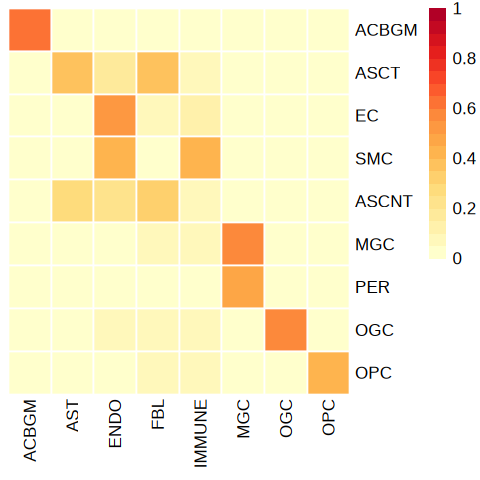

In [20]:
t1 <- imp2@meta.data[imp2$orig.ident == "MiniAtlas", c("seurat_clusters", "subclass_corrected")]
t2 <- imp2@meta.data[imp2$orig.ident == "snATAC", c("seurat_clusters", "subclass")] %>% 
filter(subclass %in% names(which(table(imp2$subclass) > 5)))
ovlp_score <- cal_ovlpScore(t1, t2)

rmat <- ovlp_score %>%
reshape2::dcast(anno1 ~ anno2) %>%
tibble::column_to_rownames("anno1") %>% t

ctk <- which(apply(rmat, 1, max) > 0.05)
rmat <- rmat[ctk, ]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ]
 
options(repr.plot.width = 4, repr.plot.height = 4)
p1 <- smat %>% 
pheatmap(cluster_rows = F, cluster_cols = F, breaks = seq(0, 1, 0.05),
         border_color = "white", angle_col = 90,
         color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(20))

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


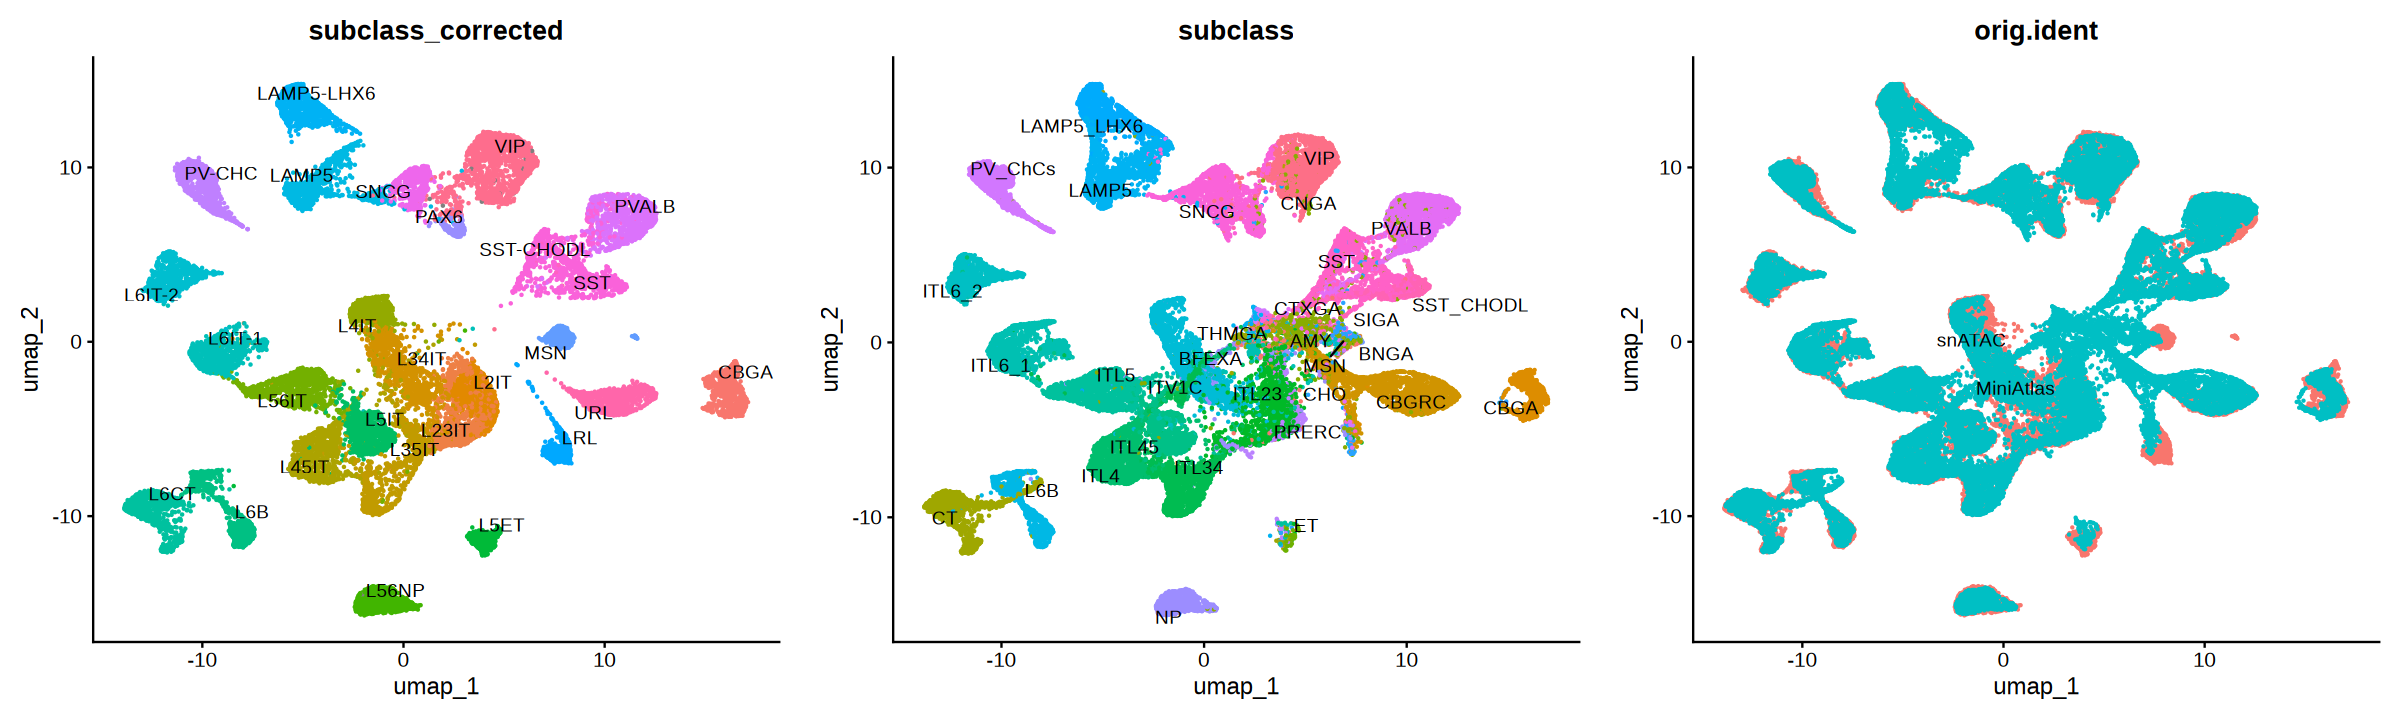

In [52]:
ref3 <- NormalizeData(ref3)
ref3 <- ScaleData(ref3, features = rownames(ref3))
transfer.anchors <- FindTransferAnchors(reference = mmg3, query = ref3, features = VariableFeatures(mmg3),
                                        reference.assay = "RNA", query.assay = "RNA", reduction = "cca")

refdata <- GetAssayData(mmg3, assay = "RNA", slot = "data")[VariableFeatures(mmg3), ]
imp3 <- TransferData(anchorset = transfer.anchors, refdata = refdata, 
                     weight.reduction = ref3[["spectral"]], dims = 1:30)

emp <- CreateSeuratObject(imp3, meta.data = ref3@meta.data)
imp3 <- merge(x = mmg3, y = emp)
imp3 <- ScaleData(imp3, features = VariableFeatures(mmg3), do.scale = FALSE)
imp3 <- RunPCA(imp3, features = VariableFeatures(mmg3), verbose = FALSE)
imp3 <- RunUMAP(imp3, dims = 1:35)
imp3 <- FindNeighbors(imp3, reduction = "pca", dims = 1:35)
imp3 <- FindClusters(imp3, resolution = 1)

imp3@meta.data[is.na(imp3$subclass_corrected), ]$orig.ident <- "snATAC"
imp3@meta.data[!is.na(imp3$subclass_corrected), ]$orig.ident <- "MiniAtlas"
imp3@meta.data[imp3$orig.ident == "MiniAtlas",]$subclass_corrected <- l3meta[rownames(imp3@meta.data[imp3$orig.ident == "MiniAtlas",]),]$subclass_corrected

options(repr.plot.width = 20, repr.plot.height = 6)
t1 <- DimPlot(imp3, group.by = c("subclass_corrected"), 
              cells = colnames(mmg3), label = T, repel = T) + NoLegend()
t2 <- DimPlot(imp3, group.by = c("subclass"), 
              cells = colnames(ref3), label = T, repel = T) + NoLegend()
t3 <- DimPlot(imp3, group.by = c("orig.ident"), label = T, repel = T) + NoLegend()

cowplot::plot_grid(t1, t2, t3, ncol = 3)

Using ovlpScore as value column: use value.var to override.



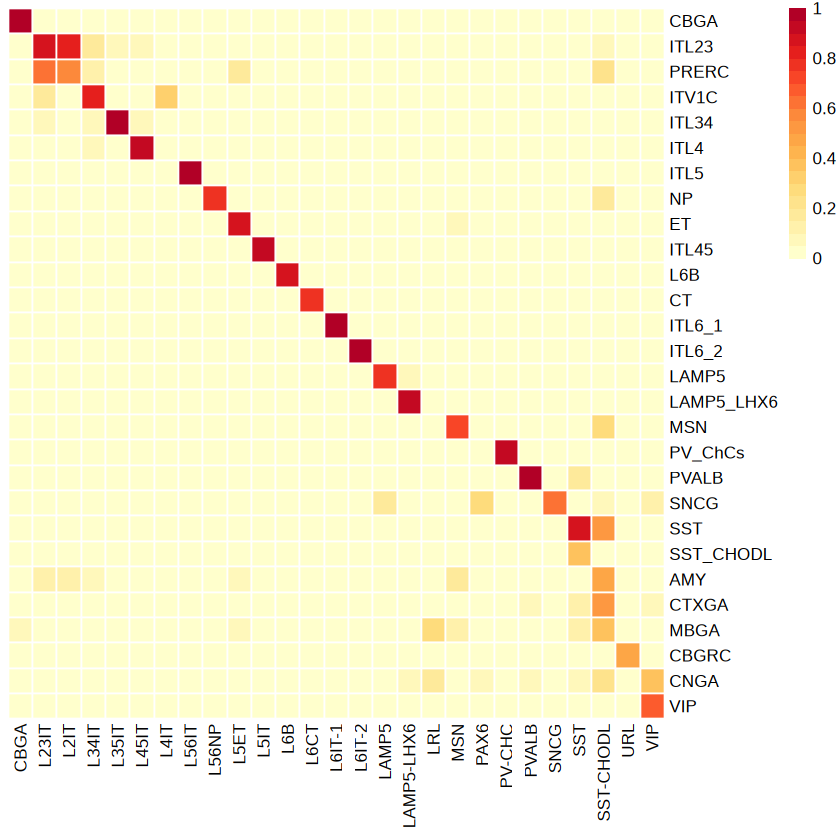

In [39]:
t1 <- imp3@meta.data[imp3$orig.ident == "MiniAtlas", c("seurat_clusters", "subclass_corrected")]
t2 <- imp3@meta.data[imp3$orig.ident == "snATAC", c("seurat_clusters", "subclass")] %>% 
filter(subclass %in% names(which(table(imp3$subclass) > 20)))
ovlp_score <- cal_ovlpScore(t1, t2)

rmat <- ovlp_score %>%
reshape2::dcast(anno1 ~ anno2) %>%
tibble::column_to_rownames("anno1") %>% t

ctk <- which(apply(rmat, 1, max) > 0.05)
rmat <- rmat[ctk, ]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat2 <- rmat[permutation_vector, ]
 
options(repr.plot.width = 7, repr.plot.height = 7)
p1 <- smat2 %>% 
pheatmap(cluster_rows = F, cluster_cols = F, breaks = seq(0, 1, 0.05),
         border_color = "white", angle_col = 90,
         color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(20))

### Finer resolution overlap

In [16]:
### On celltype level
scell <- intersect(paste0(atacmeta$sample, ":", atacmeta$barcode), colnames(imp3))
imp3$celltype <- NA
imp3@meta.data[scell,]$celltype <- atacmeta[match(scell, paste0(atacmeta$sample, ":", atacmeta$barcode)),]$celltype

Using ovlpScore as value column: use value.var to override.



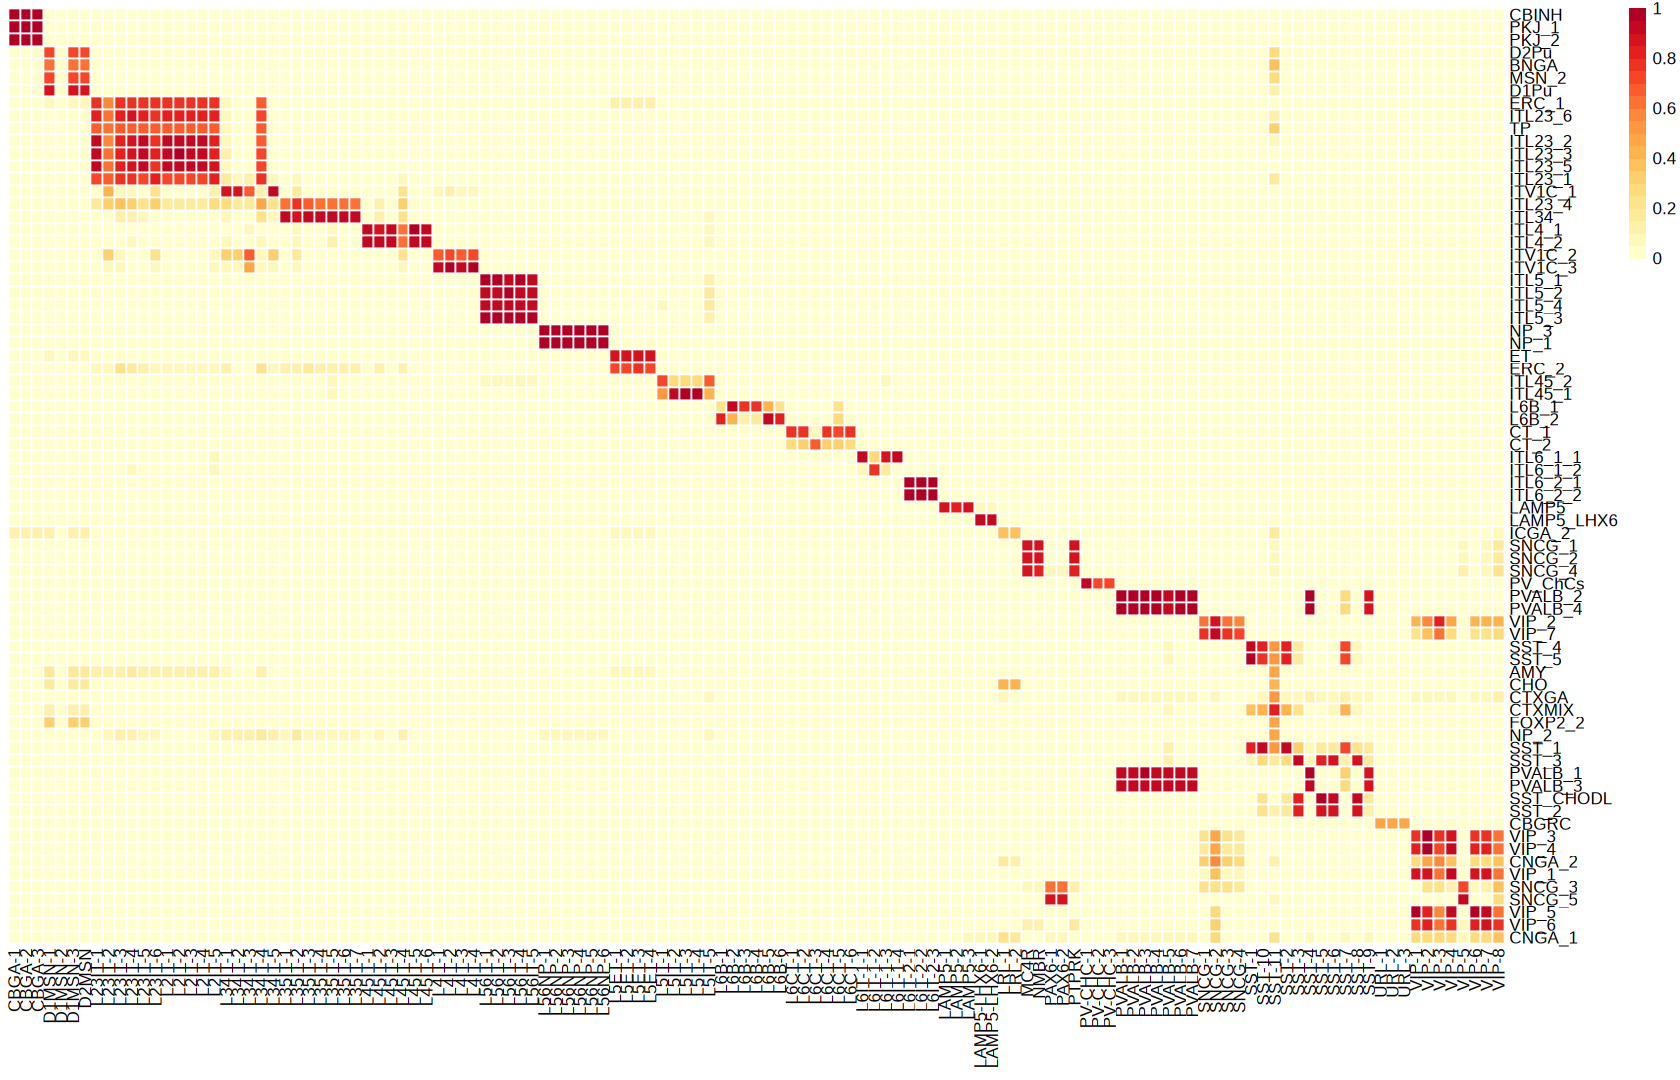

In [24]:
t1 <- imp3@meta.data[imp3$orig.ident == "MiniAtlas", c("seurat_clusters", "cluster_manual_name")] %>% 
filter(cluster_manual_name %in% names(which(table(imp3$cluster_manual_name) > 5)))
t2 <- imp3@meta.data[imp3$orig.ident == "snATAC", c("seurat_clusters", "celltype")] %>% 
filter(celltype %in% names(which(table(imp3$celltype) > 5)))
ovlp_score <- cal_ovlpScore(t1, t2)

rmat <- ovlp_score %>%
reshape2::dcast(anno1 ~ anno2) %>%
tibble::column_to_rownames("anno1") %>% t

ctk <- which(apply(rmat, 1, max) > 0.01)
rmat <- rmat[ctk, ]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat2 <- rmat[permutation_vector, ]
 
options(repr.plot.width = 14, repr.plot.height = 9)
p1 <- smat2 %>% 
pheatmap(cluster_rows = F, cluster_cols = F, breaks = seq(0, 1, 0.05),
         border_color = "white", angle_col = 90,
         color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(20))

In [31]:
# ref <- NormalizeData(ref)
# ref <- ScaleData(ref, features = VariableFeatures(mmg))

# transfer.anchors <- FindTransferAnchors(reference = mmg, query = ref, 
#                                         features = VariableFeatures(mmg),
#                                         reference.assay = "RNA", query.assay = "RNA", reduction = "cca")
mmg$subclass_corrected <- l3meta[colnames(mmg),]$subclass_corrected
celltype.predictions <- TransferData(anchorset = transfer.anchors, 
                                     refdata = mmg$subclass_corrected,
                                     weight.reduction = ref[["spectral"]], dims = 1:30)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



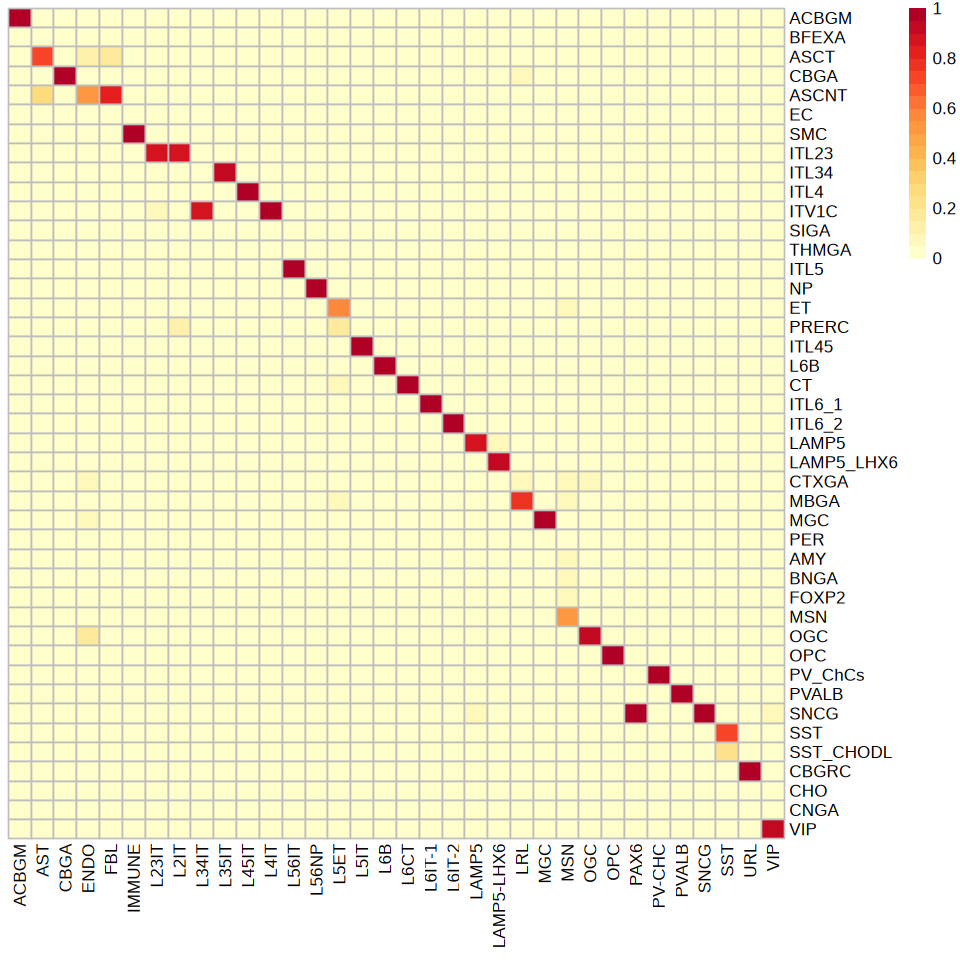

In [56]:
corder <- read.table("../04.clustering/order.subclass.250601", sep = "\t") %>% select(V1) %>% unlist %>% as.character

ref <- AddMetaData(ref, metadata = celltype.predictions)
predictions <- table(ref@meta.data[ref$prediction.score.max > 0.6,]$subclass, 
                     ref@meta.data[ref$prediction.score.max > 0.6,]$predicted.id)
rmat <- t(t(predictions)/colSums(predictions))
rmat <- rmat[, intersect(colnames(rmat), corder)]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ]
 
options(repr.plot.width = 8, repr.plot.height = 8)
p1 <- smat %>% 
pheatmap(cluster_rows = F, cluster_cols = F, breaks = seq(0, 1, 0.05),
         border_color = "grey", angle_col = 90,
         color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(20))

In [57]:
qs::qsave(ref, "snATAC_DPT_RNA_250601.pred.qs")